In [ ]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

df=pd.read_csv('dataset/big_corpus.csv')
df.head()


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1.0,False,"10 22, 2008",A74TA8X5YQ7NE,B000X9FV5M,NeuroSplicer,Recently UBISOFT had to settle a huge class-ac...,THE DAY GAMING CRIED...,1224633600,NaN,{'Format:': ' Video Game'},NaN
1,1.0,True,"03 17, 2018",A2EYD6E0TFQPVL,B014G03F24,chris,"code didn't work, got me a refund.",One Star,1521244800,NaN,NaN,NaN
2,1.0,True,"02 22, 2017",A303LKXI2SAZQ4,B003OAE79S,tammy,"these do not work at all, all i get is static ...","these do not work at all, all i get ...",1487721600,NaN,{'Size:': ' one size'},NaN
3,1.0,False,"03 23, 2012",A1JGSUX59ZTWYE,B004UDLRMS,Bear,well let me start by saying that when i first ...,last gen game,1332460800,6,{'Format:': ' Video Game'},NaN
4,1.0,False,"05 16, 2008",AXIVHIP86D1MJ,B0013B30SY,Mustang,"Dont waste your money, you will just end up us...",Waste,1210896000,4,NaN,NaN


In [ ]:
df.isnull().sum()

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          63
reviewText            30
summary               23
unixReviewTime         0
vote               85187
style              49673
image             119150
dtype: int64

In [ ]:
df.dropna(subset=['reviewText'], inplace=True)
df.shape

(119970, 12)

In [ ]:
df['overall'].value_counts()

overall
5.0    34977
3.0    24998
1.0    24996
4.0    20000
2.0    14999
Name: count, dtype: int64

In [ ]:
# text cleaning
def clean_text(text):
    text=text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df['cleaned_review'] = df['reviewText'].apply(clean_text)

In [ ]:
# create sentiment labels
def map_sentiment(rating):
  if rating<=2:
    return 0 # negative
  elif rating==3:
    return 1 # neutral
  else:
    return 2 # positive

df['sentiment']=df['overall'].apply(map_sentiment)

In [ ]:
reviews=df['cleaned_review'].values
labels=df['sentiment'].values
print('Data cleaning and labeling complete.')
print('Example review:', reviews[0])
print('Example label:', labels[0])

Data cleaning and labeling complete.
Example review: recently ubisoft had to settle a huge classaction suit brought against the company for bundling the notoriously harmful starforce drm with its released games so what the geniuses at the helm do next they decide to make the same mistake yet again  by choosing the same drm scheme that made bioshock mass effect and spore infamous securom xx with limited activations

mass effect can be found in clearance bins only months after its release spore not only undersold miserably but also made history as the boiling point of gamers lashing back fed up with idiotic drm schemes and the clueless mbas that run an artform as any other commodity business decided that hey why not jump into that mudpond ourselves

the original far cry was such a great game that any sequel of it would have to fight an uphill battle to begin with especially without its original developing team now imagine shooting this sequel on the foot with a well known much hated and 

In [ ]:
# Tokenization
voc_size=10000
tokenizer=Tokenizer(num_words=voc_size, oov_token='<OOV>')
tokenizer.fit_on_texts(reviews)
# convert text to sequences of integers
sequences=tokenizer.texts_to_sequences(reviews)

In [ ]:
# Padding
max_len = int(np.percentile([len(seq) for seq in sequences], 95))
padded_sequences=pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
print(f"Vocabulary size: {voc_size}")
print(f"Maximum sequence length: {max_len}")
print(f"Padded sequence shape: {padded_sequences.shape}")

Vocabulary size: 10000
Maximum sequence length: 569
Padded sequence shape: (119970, 569)


In [ ]:
X_train, X_test, y_train, y_test=train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# coverts labels to categorical for the model
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)


In [ ]:
# Building the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

embedding_dim = 128
model= Sequential([
    Embedding(voc_size,output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size=128
early_stopping=EarlyStopping(monitor='val_loss',min_delta=0.001, patience=3, restore_best_weights=True)
print('Training the model....')

history=model.fit(
    X_train,y_train,
    epochs=20,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping]
)
print('Training Completed!')

Training the model....
Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 120s 190ms/step - accuracy: 0.5903 - loss: 0.8999 - val_accuracy: 0.6796 - val_loss: 0.7505
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 121s 201ms/step - accuracy: 0.6841 - loss: 0.7368 - val_accuracy: 0.6886 - val_loss: 0.7657
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 121s 202ms/step - accuracy: 0.7109 - loss: 0.6813 - val_accuracy: 0.7306 - val_loss: 0.6361
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 122s 203ms/step - accuracy: 0.7407 - loss: 0.6164 - val_accuracy: 0.7334 - val_loss: 0.6427
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 122s 204ms/step - accuracy: 0.7601 - loss: 0.5808 - val_accuracy: 0.7337 - val_loss: 0.6210
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 122s 204ms/step - accuracy: 0.7878 - loss: 0.5229 - val_accuracy: 0.7487 - val_loss: 0.6037
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 122s 204ms/step - accuracy: 0.8088 - loss: 0.4784 - val_accuracy: 0.7456 - val_loss: 0.6295
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 122s 204ms/st

## Checking the overall accuracy

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

loss,accuracy=model.evaluate(X_test,y_test)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.7360 - loss: 0.6303
Test Loss: 0.6219
Test Accuracy: 73.76%


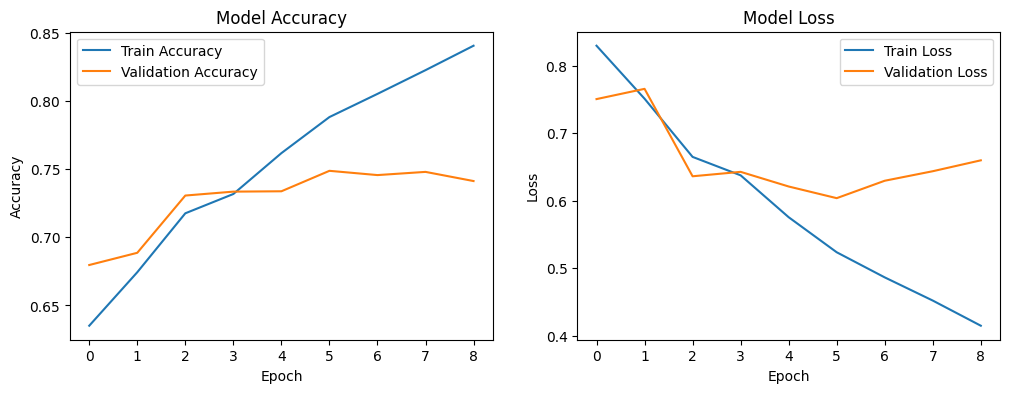

In [ ]:
# plot training history
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    plt.show()
plot_history(history)

Classification Report:
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step
              precision    recall  f1-score   support

    Negative       0.77      0.78      0.77      8092
     Neutral       0.48      0.46      0.47      5021
    Positive       0.83      0.83      0.83     10881

    accuracy                           0.74     23994
   macro avg       0.69      0.69      0.69     23994
weighted avg       0.73      0.74      0.74     23994

Confusion Matrix:
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step


<Axes: >

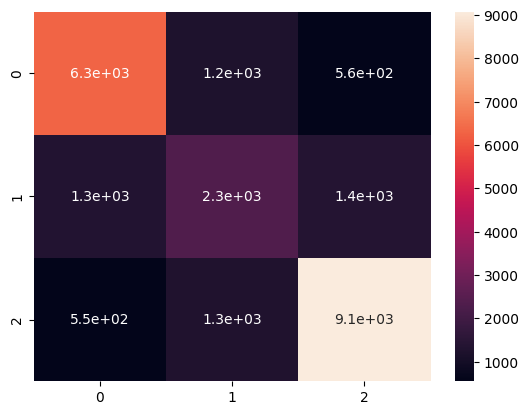

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1), target_names=['Negative', 'Neutral','Positive']))

print("Confusion Matrix:")
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
sns.heatmap(cm, annot=True)